In [1]:
import ROOT
import uproot
import math
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

In [2]:
# 可用 GPU 数量
n_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {n_gpus}")

# 每块 GPU 的名称
for i in range(n_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 当前 GPU 内存使用情况
for i in range(n_gpus):
    print(f"GPU {i} Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")
    print(f"GPU {i} Memory Cached: {torch.cuda.memory_reserved(i)/1024**3:.2f} GB")


Number of GPUs available: 1
GPU 0: NVIDIA A30
GPU 0 Memory Allocated: 0.00 GB
GPU 0 Memory Cached: 0.00 GB


Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/0.1GeV.root
threshold: 0.02282


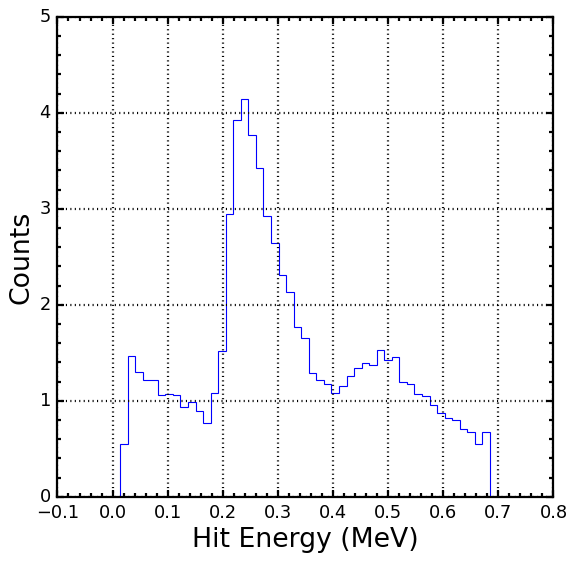

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/10.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0m

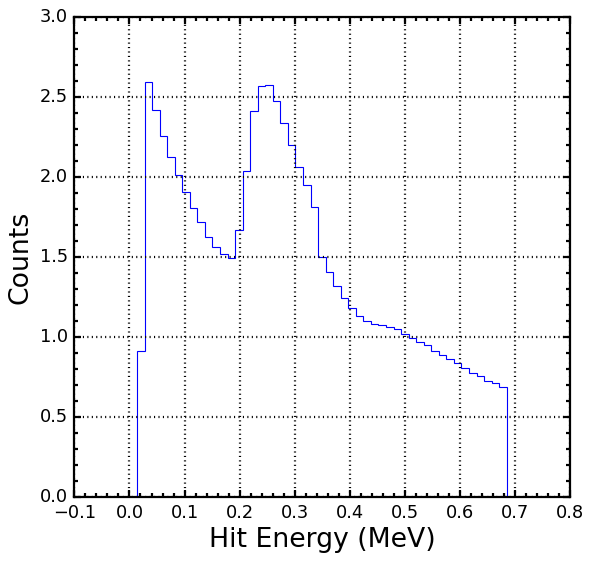

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_19.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_37.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_55.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_28.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_100.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Uniform/0_70GeV_82.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Pro

In [3]:
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
CellSize=10  # mm
SamplingLayer=30
ECAL_layers=120
Threshold=Threshold_i*MIP_table[Si]
def ReadData_Energy(DataPath,ParticleEnergy,precision=0.01):
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    NRootFiles=0
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        NRootFiles+=1
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name,draw_hist=(NRootFiles==1))
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
        E_truth_all = np.round(E_truth_all/precision)*precision
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, SamplingLayer))
    N_layers_all = np.empty((0, SamplingLayer))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file, draw_hist=(input_file == root_files[0]))
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name,draw_hist=False):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    num_events = len(energy)
    E_layers = []
    N_layers = []
    if draw_hist:
        print("threshold:", Threshold)
        plt.hist(ak.to_numpy(ak.flatten(energy))*1000,
            bins=50, range=(0, 3*MIP_table[Si]), histtype='step', density=True)
        plt.xlabel('Hit Energy (MeV)')
        plt.ylabel('Counts')
        plt.show()
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=SamplingLayer)
        N_layers_event = np.bincount(layers, minlength=SamplingLayer)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)#add 0.1 0.25 after all data is ready
E_layers_test, N_layers_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

length after zero suppression: 1249653 1249653 1249653 1249653 1249653
length after zero suppression: 59982 59982 59982 59982 59982


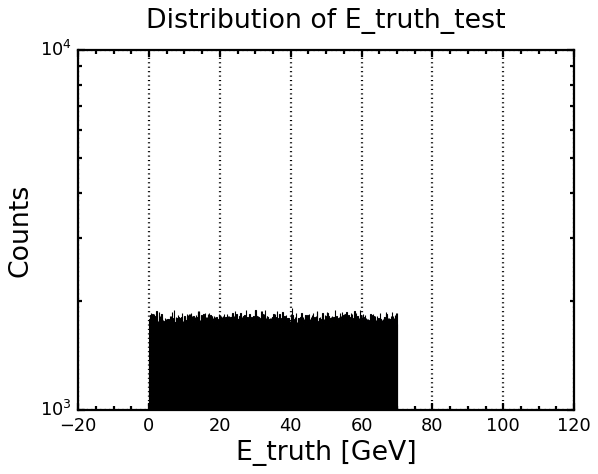

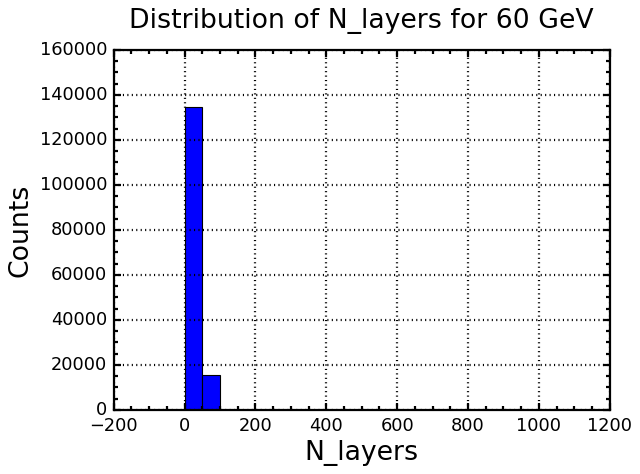

In [ ]:
#zero suppression
def zero_suppression(E_layers, N_layers,E_truth):
    N_sum = np.array([np.sum(n) for n in N_layers])
    E_sum = np.array([np.sum(e) for e in E_layers])
    E_truth = np.array(E_truth)

    mask = N_sum > 0
    E_layers_filtered = [E_layers[i] for i in range(len(E_layers)) if mask[i]]
    N_layers_filtered = [N_layers[i] for i in range(len(N_layers)) if mask[i]]    
    E_truth_filtered = E_truth[mask]
    E_sum_filtered = E_sum[mask]
    N_sum_filtered = N_sum[mask]

    print("length after zero suppression:", len(E_layers_filtered), len(N_layers_filtered), len(E_sum_filtered), len(N_sum_filtered), len(E_truth_filtered))
    return E_layers_filtered, N_layers_filtered, E_sum_filtered, N_sum_filtered, E_truth_filtered

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

def Event_Selection(E_layers,N_layers,E_truth):
    E_layers, N_layers, E_sum, N_sum, E_truth = zero_suppression(E_layers, N_layers, E_truth)
    E_layers = np.array([start_from_shower_layer(ev) for ev in E_layers])
    N_layers = np.array([start_from_shower_layer(ev) for ev in N_layers])
    return E_layers, N_layers, E_sum, N_sum, E_truth

#E_layers_train, N_layers_train, E_sum_train, N_sum_train, E_truth_train = Event_Selection(E_layers_train, N_layers_train, E_truth_train)
E_layers_uniform, N_layers_uniform, E_sum_uniform, N_sum_uniform, E_truth_uniform = Event_Selection(E_layers_uniform, N_layers_uniform, E_truth_uniform)
E_layers_test, N_layers_test, E_sum_test, N_sum_test, E_truth_test = Event_Selection(E_layers_test, N_layers_test, E_truth_test)
#Draw E_truth
plt.figure(figsize=fig_size)
plt.hist(E_truth_uniform, bins=1000, range=(0, 100), edgecolor="black")
#plt.hist(E_truth_test, bins=20, range=(0, 1), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.title("Distribution of E_truth_test")
plt.grid(True)
plt.show()
#Draw N_layers for 60 GeV
N_layers_60GeV = N_layers_test[abs(E_truth_test - 60.0) < 0.1]
N_layers_60GeV_flat = ak.flatten(N_layers_60GeV)
plt.figure(figsize=fig_size)
plt.hist(N_layers_60GeV_flat, bins=100, range=(0, 100), edgecolor="black")
plt.xlabel("N_layers")
plt.ylabel("Counts")
plt.title("Distribution of N_layers for 60 GeV")
plt.grid(True)
plt.show()


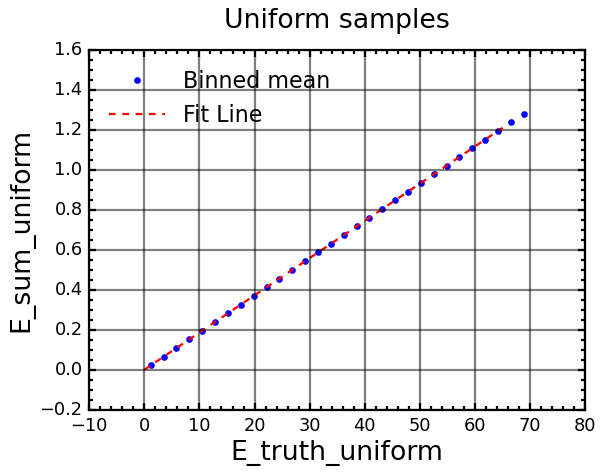

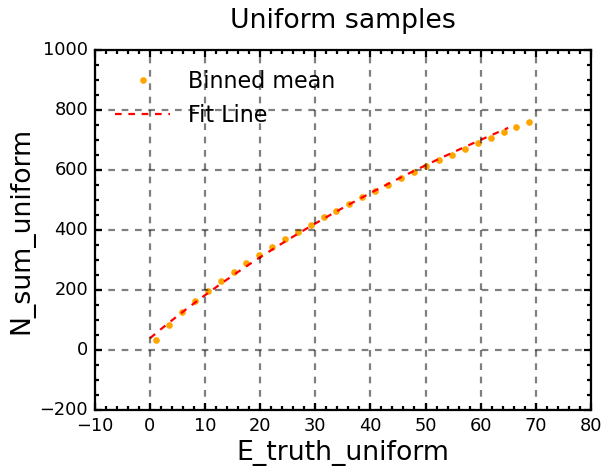

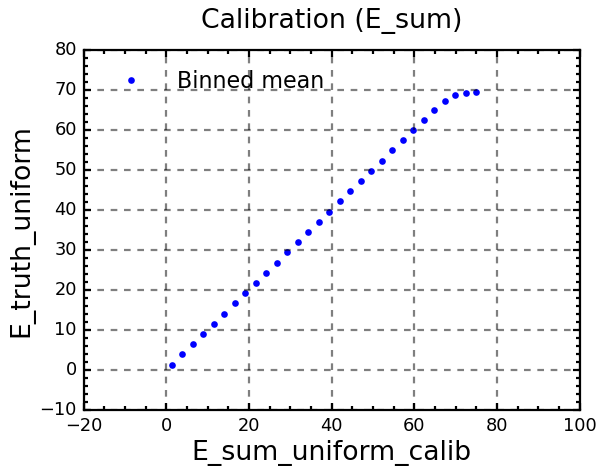

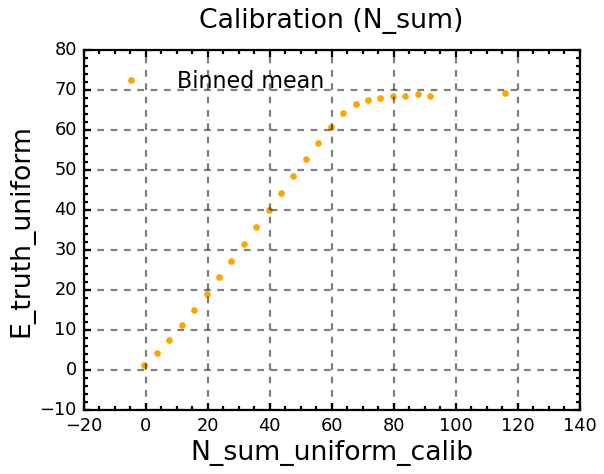

In [28]:
def plot_binned(x, y, num_bins=30, color="blue", label=None):
    """Plot mean y in bins of x."""
    bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)

def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

fit_range = (0, 65)
mask_fit = (E_truth_uniform > fit_range[0]) & (E_truth_uniform < fit_range[1])
# E_sum: linear
coeffs_calibE = np.polyfit(E_sum_uniform[mask_fit], E_truth_uniform[mask_fit], 1)
coeffs_calibE_inv = np.polyfit(E_truth_uniform[mask_fit], E_sum_uniform[mask_fit], 1)
E_fit_line = np.poly1d(coeffs_calibE_inv)
# N_sum: exponential
coeffs_calibN, _ = curve_fit(exp_func, N_sum_uniform[mask_fit], E_truth_uniform[mask_fit], p0=(1,0.01,1))
E_fit = exp_func(N_sum_uniform, *coeffs_calibN)
interp_inv = interp1d(E_fit, N_sum_uniform, bounds_error=False, fill_value="extrapolate")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, E_sum_uniform, color="blue", label="Binned mean")
X_line=np.linspace(fit_range[0], fit_range[1], 200)
plt.plot(X_line, E_fit_line(X_line), color="red", linestyle="--", label="Fit Line")
plt.ylabel("E_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="-", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(E_truth_uniform, N_sum_uniform, color="orange", label="Binned mean")
E_vals = np.linspace(fit_range[0], fit_range[1], 200)
N_vals = interp_inv(E_vals)
plt.plot(E_vals, N_vals, color="red", linestyle="--", label="Fit Line")
plt.ylabel("N_sum_uniform")
plt.xlabel("E_truth_uniform")
plt.title("Uniform samples")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

E_calib = np.poly1d(coeffs_calibE)
E_sum_uniform_calib = E_calib(E_sum_uniform)
#E_sum_train_calib   = E_calib(E_sum_train)
E_sum_test_calib    = E_calib(E_sum_test)
N_sum_uniform_calib = exp_func(N_sum_uniform, *coeffs_calibN)
#N_sum_train_calib   = exp_func(N_sum_train, *coeffs_calibN)
N_sum_test_calib    = exp_func(N_sum_test, *coeffs_calibN)

plt.figure(figsize=fig_size)
plot_binned(E_sum_uniform_calib,E_truth_uniform, color="blue", label="Binned mean")
plt.xlabel("E_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (E_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")

plt.figure(figsize=fig_size)
plot_binned(N_sum_uniform_calib, E_truth_uniform, color="orange", label="Binned mean")
plt.xlabel("N_sum_uniform_calib")
plt.ylabel("E_truth_uniform")
plt.title("Calibration (N_sum)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")
plt.show()

In [29]:
from sklearn import base


class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        return torch.mean(rel**2)
class RelativeMSELoss_Power3(nn.Module):
    def __init__(self, eps=1e-8, power=3):
        super().__init__()
        self.eps = eps
        self.power = power
    def forward(self, y_pred, y_true):
        out = ((y_pred - y_true)**2) / ((y_true + self.eps)**self.power)
        return torch.mean(out)   
class HuberRelativeLoss(nn.Module):
    def __init__(self, delta=0.1, eps=1e-8):
        super().__init__()
        self.delta = delta
        self.eps = eps
    def forward(self, y_pred, y_true):
        rel = (y_pred - y_true) / (y_true + self.eps)
        abs_rel = torch.abs(rel)
        #Basic
        loss = torch.where(abs_rel < self.delta, 0.5 * rel**2, self.delta * (abs_rel - 0.5*self.delta))
        #Test
        #loss = torch.where(square < 0.01, 0.5 * rel**3, self.delta * (abs_rel - 0.5*self.delta))
        # base = torch.where(abs_rel < self.delta,
        #            0.5 * rel**2,
        #            self.delta * (abs_rel - 0.5*self.delta))
        # loss = base * (1 + abs_rel)
        return torch.mean(loss)

class ResidualLinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, activation=None):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = activation if activation is not None else nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Linear(in_features, out_features) if in_features != out_features else nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.activation(x)
        #out = x
        out = self.linear(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = out + identity
        return out

class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], dropout=0.1, activation=nn.PReLU()):
        super().__init__()
        print(f"Hidden dims: {hidden_dims}, Dropout: {dropout}, Activation: {activation}")
        layers = []
        prev_dim = input_dim
        print(f"Input dim: {input_dim}")
        for h in hidden_dims:
            layers.append(ResidualLinearBlock(prev_dim, h, dropout=dropout, activation=activation))
            prev_dim = h
        self.model = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, 1)

    def forward(self, x):
        x = self.model(x)
        return self.output_layer(x).squeeze(-1)

# ==== Training function ====
def train_mlp(X_train,y_train,
            activation=nn.Sigmoid(),
            loss=HuberRelativeLoss(),
              hidden_dims=[128, 64, 32], 
              dropout=0.1, 
              lr=1e-3,
              weight_decay=5e-5, 
              batch_size=4096, 
              epochs=500,
              patience=10,
              val_split=0.2,
              random_state=42):
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.cuda.manual_seed_all(random_state)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    val_split = 0.2
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=val_split, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_validate_tensor = torch.tensor(X_validate_scaled, dtype=torch.float32)
    y_validate_tensor = torch.tensor(y_validate, dtype=torch.float32)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_validate_tensor, y_validate_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    print(f"Random state: {random_state}")
    print(f"Training samples: {len(X_train)}, Validation samples: {int(len(X_validate))}")
    print(f"learning rate: {lr}, batch size: {batch_size}, epochs: {epochs}, patience: {patience}")
    print(f"Loss function: {loss}")
    # Model
    model = MLPRegressor(input_dim=X_train.shape[1], hidden_dims=hidden_dims, dropout=dropout,
                         activation=activation).to(device)

    # Optimizer & Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = loss

    warmup_epochs = 5
    base_lr = lr
    min_lr = 1e-5

    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return float(current_epoch + 1) / warmup_epochs
        else:
            progress = 2 * (current_epoch - warmup_epochs) / (epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))  # 范围 0~1
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
    # === Training loop with best model tracking ===
    best_val_loss = float("inf")
    best_state_dict = None
    train_loss_history, val_loss_history, beta_history = [],  [], []
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        scheduler.step()
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                val_loss += loss.item() * xb.size(0)

        train_loss /= len(train_dataset)
        val_loss   /= len(val_dataset)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}| LR: {scheduler.get_last_lr()[0]:.6f}")

        # Nan stopping
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("NaN encountered. Stopping training.")
            break
        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    plt.figure(figsize=fig_size)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Restore best model
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    model.eval()
    y_validate_pred_list = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)      
            pred = model(xb)
            y_validate_pred_list.append(pred.detach().cpu().numpy())
    y_validate_pred = np.concatenate(y_validate_pred_list, axis=0)

    return model,scaler,y_validate, y_validate_pred, best_val_loss

In [30]:
E_layers_uniform_ratio = E_layers_uniform / (E_sum_uniform[:, np.newaxis])
N_layers_uniform_ratio = N_layers_uniform / (N_sum_uniform[:, np.newaxis])
E_layers_test_ratio    = E_layers_test / (E_sum_test[:, np.newaxis])
N_layers_test_ratio    = N_layers_test / (N_sum_test[:, np.newaxis])
#performance not good
# E_layers_uniform_exp = np.exp(E_layers_uniform_ratio)
# N_layers_uniform_exp = np.exp(N_layers_uniform_ratio)
# E_layers_test_exp    = np.exp(E_layers_test_ratio)
# N_layers_test_exp    = np.exp(N_layers_test_ratio)

E_N_layers_uniform =  E_layers_uniform/(N_layers_uniform+1e-6)
E_N_layers_test    =  E_layers_test/(N_layers_test+1e-6)
#EN_layers_uniform = E_N_layers_uniform * N_layers_uniform
#EN_layers_test    = E_N_layers_test * N_layers_test

LayerNum_uniform = np.array([np.sum(e>0) for e in E_layers_uniform])
LayerNum_test    = np.array([np.sum(e>0) for e in E_layers_test])
Average_E_layer_uniform = E_sum_uniform / (LayerNum_uniform + 1e-6) 
Average_E_layer_test    = E_sum_test / (LayerNum_test + 1e-6)
Average_N_layer_uniform = N_sum_uniform / (LayerNum_uniform + 1e-6)
Average_N_layer_test    = N_sum_test / (LayerNum_test + 1e-6)

In [31]:
X_train = np.hstack([
    E_layers_uniform, 
    E_layers_uniform_ratio,
    E_sum_uniform_calib[:, np.newaxis],
    N_layers_uniform, 
    N_layers_uniform_ratio,
    N_sum_uniform_calib[:, np.newaxis],
    E_N_layers_uniform,
    LayerNum_uniform[:, np.newaxis],
    Average_E_layer_uniform[:, np.newaxis],
    Average_N_layer_uniform[:, np.newaxis],
])
X_test = np.hstack(
    [E_layers_test, 
    E_layers_test_ratio,
    E_sum_test_calib[:,np.newaxis], 
    N_layers_test, 
    N_layers_test_ratio,
    N_sum_test_calib[:,np.newaxis],
    E_N_layers_test,
    LayerNum_test[:, np.newaxis],
    Average_E_layer_test[:, np.newaxis],
    Average_N_layer_test[:, np.newaxis],
])
y_train = E_truth_uniform
y_test = E_truth_test

def plot_features_in_batches(X, feature_names=None, bins=50, n_cols=2, figsize=(12, 6)):
    n_features = X.shape[1]
    n_rows = (n_cols + n_cols - 1) // n_cols  # 每页只有 1 行 2 列的话 n_rows=1
    for start in range(0, n_features, n_cols):
        end = min(start + n_cols, n_features)
        plt.figure(figsize=figsize)
        for i, j in enumerate(range(start, end)):
            plt.subplot(1, n_cols, i + 1)
            plt.hist(X[:, j], bins=bins, color='skyblue', edgecolor='black')
            plt.yscale('log')
            if feature_names:
                plt.title(feature_names[j], fontsize=10)
            else:
                plt.title(f"Feature {j}", fontsize=10)
        plt.subplots_adjust(hspace=0.4, wspace=0.3)
        plt.show()
#plot_features_in_batches(X_train, bins=50, n_cols=2, figsize=(12, 6))

Using device: cuda
Random state: 42
Training samples: 999722, Validation samples: 249931
learning rate: 0.0005, batch size: 4096, epochs: 100, patience: 10
Loss function: HuberRelativeLoss()
Hidden dims: [256, 128, 64], Dropout: 0.1, Activation: PReLU(num_parameters=1)
Input dim: 155
Epoch 001/100 | Train Loss: 0.032226 | Val Loss: 0.008948| LR: 0.000200
Epoch 002/100 | Train Loss: 0.006307 | Val Loss: 0.004622| LR: 0.000300
Epoch 003/100 | Train Loss: 0.003937 | Val Loss: 0.006012| LR: 0.000400
Epoch 004/100 | Train Loss: 0.003510 | Val Loss: 0.001927| LR: 0.000500
Epoch 005/100 | Train Loss: 0.003006 | Val Loss: 0.001689| LR: 0.000500
Epoch 006/100 | Train Loss: 0.002597 | Val Loss: 0.001671| LR: 0.000499
Epoch 007/100 | Train Loss: 0.002372 | Val Loss: 0.001803| LR: 0.000498
Epoch 008/100 | Train Loss: 0.002062 | Val Loss: 0.001969| LR: 0.000495
Epoch 009/100 | Train Loss: 0.001877 | Val Loss: 0.001363| LR: 0.000491
Epoch 010/100 | Train Loss: 0.001711 | Val Loss: 0.001244| LR: 0.00

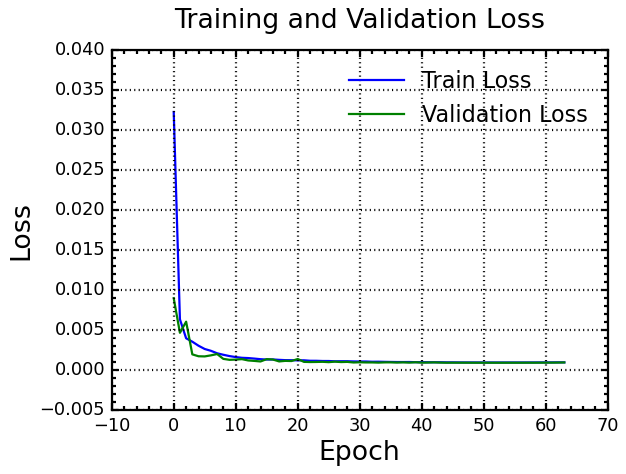

In [32]:
ParameterScan=[1e-3,]#not used, but the loop is kept for future parameter scanning
Reco_hist_mlp_all = []
MLP_Config="WD1e-8"
for lr in ParameterScan:
  mlp_model,scaler,y_validate, y_validate_pred, best_val_loss = train_mlp(X_train, y_train,
                    activation=nn.PReLU(),
                    hidden_dims=[256, 128, 64],
                      dropout=0.1,
                    loss=HuberRelativeLoss(delta=0.05),
                    lr=5e-4,
                    weight_decay=1e-8,
                    batch_size=4096,
                    epochs=100,
                      patience=10,
                      random_state=42)
  device = next(mlp_model.parameters()).device
  torch.save(mlp_model, DataPath_Validate+f"/Models/MLP.pth")

Step 1 Linear fit coeffs: [ 0.00027695 -0.01633915]


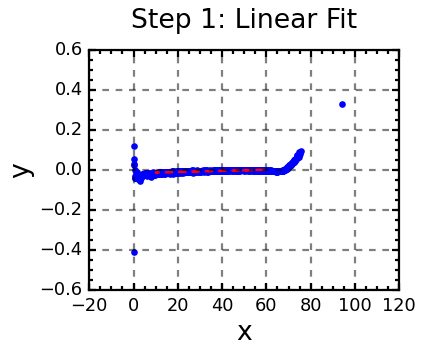

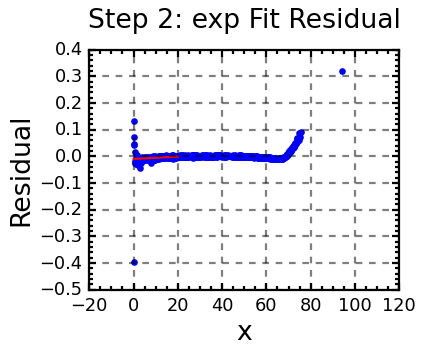

Step 3 Linear fit coeffs: [-0.00014174 -0.00722623]


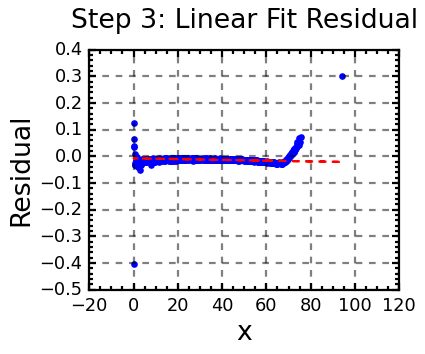

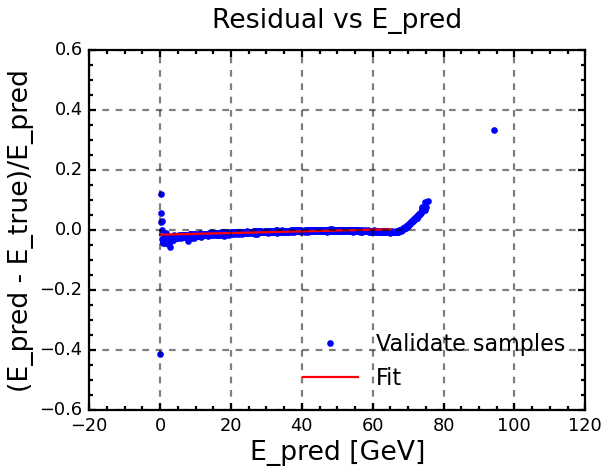

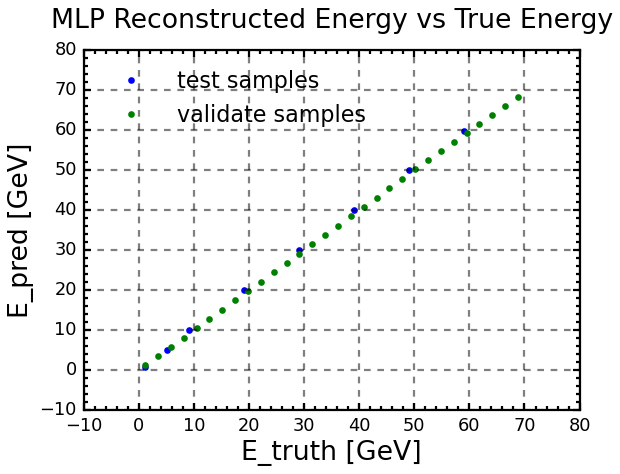

In [33]:
def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
    #Step 1: Linear
    linear_range = (10,60)
    mask_lin = (x > linear_range[0]) & (x < linear_range[1])
    coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
    y_lin = np.poly1d(coeffs_lin)(x)
    residual = y - y_lin
    print("Step 1 Linear fit coeffs:", coeffs_lin)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
        plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Step 1: Linear Fit")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Step 2: exp fit
    #residual = y
    fit_range = (0.1, 20)
    mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    def fit_func2(x, a, b, c):
        return a * np.exp(b * x) + c
    coeff_fit2, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
    y_fit2 = fit_func2(x_fit2, *coeff_fit2)
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
        plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 2: exp Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()

    residual = y - fit_func2(x, *coeff_fit2)

    # Step 3: exp fit
    # if plot:
    #     plt.figure(figsize=(5,4))
    #     plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
    #     plt.xlabel("x")
    #     plt.ylabel("Residual")
    #     plt.title("Step 3: exp Fit Residual")
    #     plt.grid(True, linestyle="--", alpha=0.5)
    #     plt.show()
    # fit_range = (10, 30)
    # mask_fit = (x > fit_range[0]) & (x < fit_range[1])
    # def fit_func3(x, a, b, c):
    #     return a * np.exp(b * x) + c
    # coeff_fit3, _ = curve_fit(fit_func3, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
    # x_fit3 = np.linspace(fit_range[0], fit_range[1], 200)
    # y_fit3 = fit_func3(x_fit3, *coeff_fit3)
    # if plot:
    #     plt.plot(x_fit3, y_fit3, color="red", linestyle="-", label="Step3: exp Fit")

    # residual = y - fit_func2(x, *coeff_fit2) - fit_func3(x, *coeff_fit3)

    # Step 4: Linear again
    mask_fit = (x > linear_range[0]) & (x < linear_range[1])
    params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
    y_lin2 = np.poly1d(params_lin2)(x)
    print("Step 3 Linear fit coeffs:", params_lin2)
    
    if plot:
        plt.figure(figsize=(5,4))
        plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
        plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
        plt.xlabel("x")
        plt.ylabel("Residual")
        plt.title("Step 3: Linear Fit Residual")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
    
    # Final combined function
    def f(x_val):
        return ( 
                fit_func2(x_val, *coeff_fit2) + 
                #fit_func3(x_val, *coeff_fit3) + 
                np.poly1d(params_lin2)(x_val))
    return f
def build_reco_hist(y_pred, y_truth, Energy_test, Nbins=50):
    reco_hist = []
    for i_E, E_truth in enumerate(Energy_test):
        mask = (y_truth == E_truth)
        reco_energy = y_pred[mask]

        if len(reco_energy) == 0:
            print(f"No events found for E_truth = {E_truth} GeV, skipping.")
            continue

        mean = np.mean(reco_energy)
        rms = np.std(reco_energy)
        valid_mask = (reco_energy >= mean - 5*rms) & (reco_energy <= mean + 5*rms)

        filtered_data = reco_energy[valid_mask]
        counts, bin_edges = np.histogram(filtered_data, bins=Nbins)

        reco_hist.append({
            "E_truth": E_truth,
            "counts": counts,
            "bin_edges": bin_edges
        })
    return reco_hist

y_pred=y_validate_pred
y_true=y_validate
X_test_scaled = scaler.transform(X_test)
mlp_model.eval()
y_pred_test_mlp_list = []
batch_size_pred = 4096
with torch.no_grad():
    for i in range(0, len(X_test_scaled), batch_size_pred):
        batch = torch.tensor(X_test_scaled[i:i+batch_size_pred], dtype=torch.float32).to(device)
        preds = mlp_model(batch)
        y_pred_test_mlp_list.append(preds.detach().cpu().numpy())
        del batch, preds
        torch.cuda.empty_cache()
y_pred_test_mlp = np.concatenate(y_pred_test_mlp_list, axis=0)

Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp, E_truth_test, Energy_test, Nbins=30)
Reco_hist_mlp_all.append(Reco_hist_mlp)

Nbins=1000
fit_range = (0, 65) 
mask = y_pred>0
residual_E = (y_pred[mask] - y_true[mask]) / y_pred[mask]
E_calib_fit = Combined_fit(y_pred[mask], residual_E, fit_range=fit_range, plot=True, num_bins=Nbins)
x_fit = np.linspace(fit_range[0], fit_range[1], Nbins)
y_fit = E_calib_fit(x_fit)
plt.figure(figsize=fig_size)
plot_binned(y_pred[mask], residual_E, num_bins=Nbins, color="blue", label="Validate samples")
#plot_binned(y_pred_test_mlp, (y_pred_test_mlp - y_test) / y_pred_test_mlp,num_bins=200, color="orange", label="Test samples")
plt.plot(x_fit, y_fit, color='red', label='Fit')
plt.xlabel("E_pred [GeV]")
plt.ylabel("(E_pred - E_true)/E_pred")
plt.title("Residual vs E_pred")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

y_pred_calib = y_pred*(1-E_calib_fit(y_pred))
y_pred_test_mlp_calib = y_pred_test_mlp*(1-E_calib_fit(y_pred_test_mlp))
Reco_hist_mlp_all.clear()
Reco_hist_mlp = build_reco_hist(y_pred_test_mlp_calib, E_truth_test, Energy_test, Nbins=50)
Reco_hist_mlp_all.append(Reco_hist_mlp)

plt.figure(figsize=fig_size)
plot_binned(y_test, y_pred_test_mlp, color="blue", label="test samples")
plot_binned(y_true, y_pred, color="green", label="validate samples")
plt.xlabel("E_truth [GeV]")
plt.ylabel("E_pred [GeV]")
plt.title("MLP Reconstructed Energy vs True Energy")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left")  
plt.show()


In [34]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = bin_edges[0] # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1-1, mu*0.1-1, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    print(f"Gamma Fit Bounds: lower {lower_bounds}, \n upper {upper_bounds}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Mean: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


In [35]:
# #This cell is left here for debug
# print("length of Reco_hist_mlp_all:", len(Reco_hist_mlp_all))
# Reco_hist_mlp = Reco_hist_mlp_all[0] # Example for first beta
# print("length of Reco_hist_mlp:", len(Reco_hist_mlp))
# i_E = 6 # Example index, change as needed
# #print(len(Reco_hist_mlp))
# #print(Reco_hist_mlp[i_E])
# mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all(
#     "E_reco",Reco_hist_mlp[i_E]["E_truth"],Reco_hist_mlp[i_E]["counts"],Reco_hist_mlp[i_E]["bin_edges"])

Mean: 0.1383686190239553, Peak: 0.11850996167205094, RMS: 0.054178447993737854
Initial Gamma Fit Parameters: [np.float64(91.59160435750731), np.float64(5.289826703506174), np.float64(-0.1482259819278397), np.float64(0.054178447993737854)]
Gamma Fit Bounds: lower [np.float64(0.9159160435750731), np.float64(-0.4710173296493826), np.float64(-1.0148225981927839), np.float64(0.005417844799373786)], 
 upper [np.float64(549.5496261450438), np.float64(52.898267035061735), np.float64(9.777661027108241), np.float64(0.5417844799373785)]


Gamma Fit Parameters: [ 9.13426832e+01  5.28982670e+01 -2.33656122e-01  7.04679854e-03]
Gamma Fit Peak: 0.13206051055742962 ± 0.0022250655674657654, Mean: 0.13910730909580382 ± 0.0022427856442676646, Resolution: 0.38809639259385076 ± 0.01420343634189086


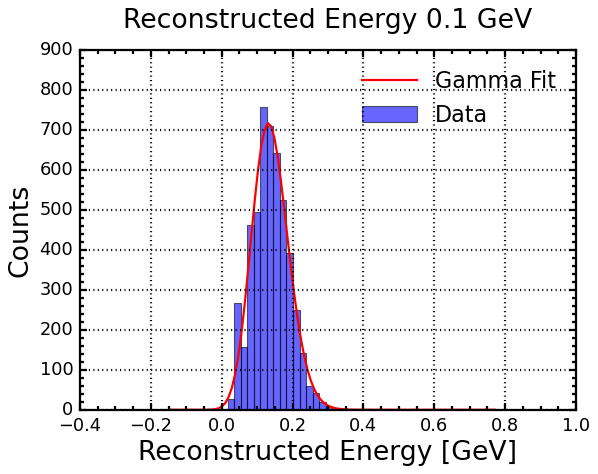

appending results for E = 0.1
Mean_Gamma: 0.13910730909580382 Mean_Gamma_Error: 0.0022427856442676646
Peak_Gamma: 0.13206051055742962 Peak_Gamma_Error: 0.0022250655674657654
Mean: 0.29159189505449157, Peak: 0.2588571405125125, RMS: 0.07520900662821577
Initial Gamma Fit Parameters: [np.float64(70.58580970762858), np.float64(4.1035826399105), np.float64(-0.01703447890996842), np.float64(0.07520900662821577)]
Gamma Fit Bounds: lower [np.float64(0.7058580970762859), np.float64(-0.58964173600895), np.float64(-1.0017034478909967), np.float64(0.007520900662821577)], 
 upper [np.float64(423.5148582457715), np.float64(41.035826399105), np.float64(9.974448281635047), np.float64(0.7520900662821577)]
Gamma Fit Parameters: [7.01881148e+01 1.30402344e+01 2.50491764e-02 2.06252350e-02]
Gamma Fit Peak: 0.27338183988832826 ± 0.001268962703813538, Mean: 0.29400707487822064 ± 0.0013108066771950094, Resolution: 0.272440671443553 ± 0.004269997250511699


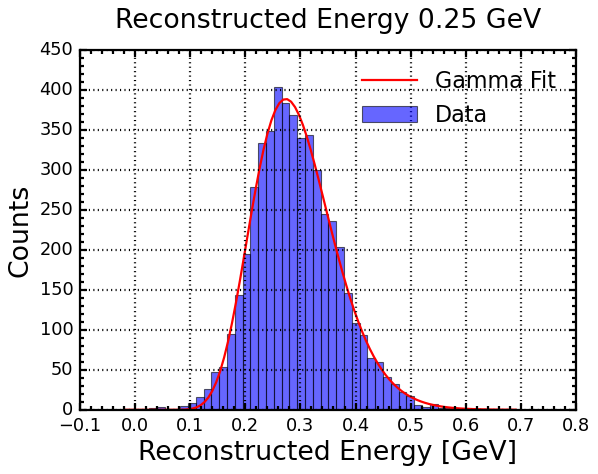

appending results for E = 0.25
Mean_Gamma: 0.29400707487822064 Mean_Gamma_Error: 0.0013108066771950094
Peak_Gamma: 0.27338183988832826 Peak_Gamma_Error: 0.001268962703813538
Mean: 0.5352123974935292, Peak: 0.512057496477619, RMS: 0.10183550166427992
Initial Gamma Fit Parameters: [np.float64(86.52769930580484), np.float64(4.563350635102003), np.float64(0.07050129629790637), np.float64(0.10183550166427992)]
Gamma Fit Bounds: lower [np.float64(0.8652769930580485), np.float64(-0.5436649364897996), np.float64(-0.9929498703702093), np.float64(0.010183550166427992)], 
 upper [np.float64(519.1661958348291), np.float64(45.63350635102003), np.float64(10.10575194444686), np.float64(1.0183550166427993)]
Gamma Fit Parameters: [ 8.59367656e+01  3.34213379e+01 -3.62482247e-02  1.71301706e-02]
Gamma Fit Peak: 0.5191348258553307 ± 0.002381028931535758, Mean: 0.5362649964969706 ± 0.0024107230913439836, Resolution: 0.19076269116470576 ± 0.0035166274250183096


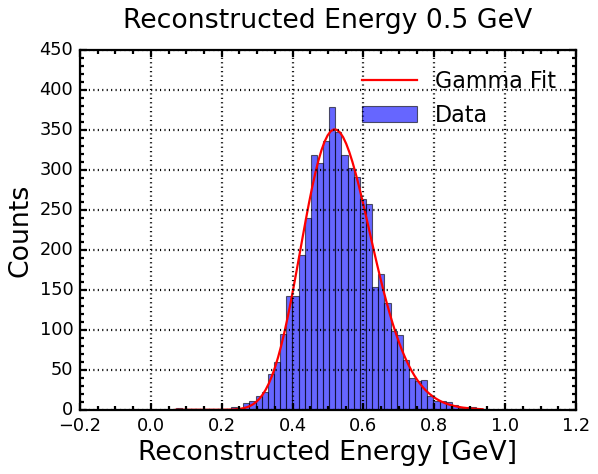

appending results for E = 0.5
Mean_Gamma: 0.5362649964969706 Mean_Gamma_Error: 0.0024107230913439836
Peak_Gamma: 0.5191348258553307 Peak_Gamma_Error: 0.002381028931535758
Mean: 1.019947824792793, Peak: 0.9893795238595727, RMS: 0.1585408246642343
Initial Gamma Fit Parameters: [np.float64(139.0329233911141), np.float64(4.141470008406418), np.float64(0.363355754337846), np.float64(0.1585408246642343)]
Gamma Fit Bounds: lower [np.float64(1.390329233911141), np.float64(-0.5858529991593582), np.float64(-0.9636644245662154), np.float64(0.01585408246642343)], 
 upper [np.float64(834.1975403466847), np.float64(41.41470008406418), np.float64(10.545033631506769), np.float64(1.5854082466423431)]
Gamma Fit Parameters: [1.39073749e+02 4.14147001e+01 6.22136186e-03 2.45403802e-02]
Gamma Fit Peak: 0.998013465749161 ± 0.002794781928918313, Mean: 1.0225538459116712 ± 0.002822560947217521, Resolution: 0.15824213923691743 ± 0.002063631307373981


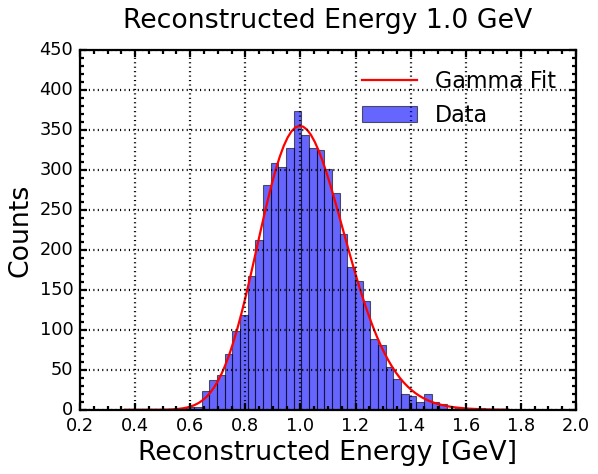

appending results for E = 1.0
Mean_Gamma: 1.0225538459116712 Mean_Gamma_Error: 0.002822560947217521
Peak_Gamma: 0.998013465749161 Peak_Gamma_Error: 0.002794781928918313
Mean: 2.0033985305943576, Peak: 2.016623208402974, RMS: 0.23276815687855607
Initial Gamma Fit Parameters: [np.float64(173.48278827401583), np.float64(3.5959000711282756), np.float64(1.1663874987183602), np.float64(0.23276815687855607)]
Gamma Fit Bounds: lower [np.float64(1.7348278827401584), np.float64(-0.6404099928871725), np.float64(-0.883361250128164), np.float64(0.02327681568785561)], 
 upper [np.float64(1040.896729644095), np.float64(35.959000711282755), np.float64(11.74958124807754), np.float64(2.3276815687855605)]
Gamma Fit Parameters: [1.73449382e+02 3.59590007e+01 6.13326608e-01 3.88349142e-02]
Gamma Fit Peak: 1.9709564011813248 ± 0.005068917889710765, Mean: 2.0097913153893683 ± 0.0051282019917148584, Resolution: 0.11815419339302803 ± 0.0018775249023802174


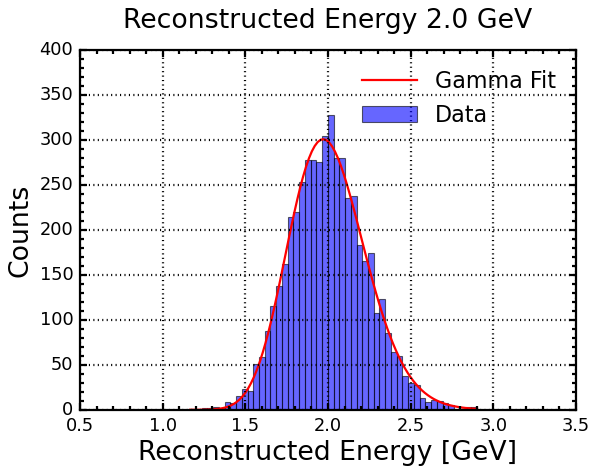

appending results for E = 2.0
Mean_Gamma: 2.0097913153893683 Mean_Gamma_Error: 0.0051282019917148584
Peak_Gamma: 1.9709564011813248 Peak_Gamma_Error: 0.005068917889710765
Mean: 4.9928966487496105, Peak: 4.95107531041759, RMS: 0.3966672010313145
Initial Gamma Fit Parameters: [np.float64(340.18143888609967), np.float64(4.824114385750576), np.float64(3.0793286978990304), np.float64(0.3966672010313145)]
Gamma Fit Bounds: lower [np.float64(3.4018143888609966), np.float64(-0.5175885614249424), np.float64(-0.6920671302100969), np.float64(0.03966672010313145)], 
 upper [np.float64(2041.0886333165981), np.float64(48.24114385750576), np.float64(14.618993046848546), np.float64(3.966672010313145)]
Gamma Fit Parameters: [3.38711119e+02 4.82411439e+01 2.29224306e+00 5.64206309e-02]
Gamma Fit Peak: 4.957618198415615 ± 0.00904829355366071, Mean: 5.014038829310372 ± 0.009127351637497378, Resolution: 0.07904486448348996 ± 0.0012752739385751412


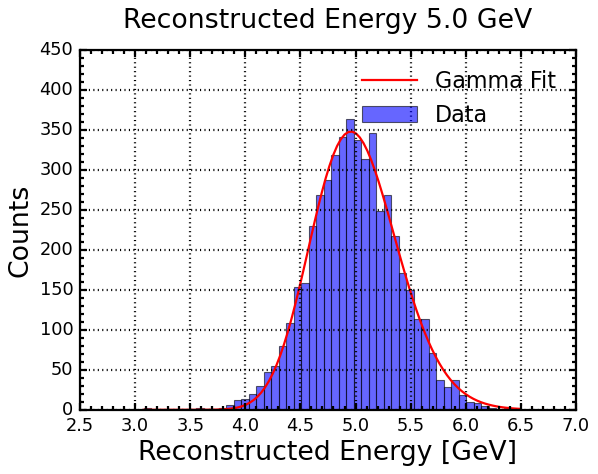

appending results for E = 5.0
Mean_Gamma: 5.014038829310372 Mean_Gamma_Error: 0.009127351637497378
Peak_Gamma: 4.957618198415615 Peak_Gamma_Error: 0.00904829355366071
Mean: 10.011778776606397, Peak: 9.763094736882067, RMS: 0.5794442585607963
Initial Gamma Fit Parameters: [np.float64(524.7173162471422), np.float64(4.505794635774144), np.float64(7.400921944653034), np.float64(0.5794442585607963)]
Gamma Fit Bounds: lower [np.float64(5.247173162471422), np.float64(-0.5494205364225855), np.float64(-0.2599078055346965), np.float64(0.05794442585607963)], 
 upper [np.float64(3148.3038974828532), np.float64(45.05794635774144), np.float64(21.101382916979553), np.float64(5.794442585607963)]
Gamma Fit Parameters: [5.25069812e+02 4.50579464e+01 6.13091214e+00 8.66628601e-02]
Gamma Fit Peak: 9.94909978235728 ± 0.0133998336543946, Mean: 10.035762642462908 ± 0.013521546739570171, Resolution: 0.05847024694935079 ± 0.0009371611269019251


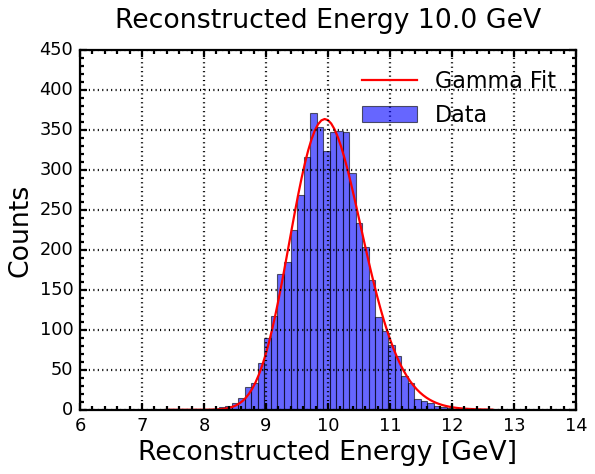

appending results for E = 10.0
Mean_Gamma: 10.035762642462908 Mean_Gamma_Error: 0.013521546739570171
Peak_Gamma: 9.94909978235728 Peak_Gamma_Error: 0.0133998336543946
Mean: 20.05326542156387, Peak: 19.99079123284917, RMS: 0.8338770482397918
Initial Gamma Fit Parameters: [np.float64(730.6205449390841), np.float64(4.545190490901686), np.float64(16.263135391323203), np.float64(0.8338770482397918)]
Gamma Fit Bounds: lower [np.float64(7.306205449390841), np.float64(-0.5454809509098313), np.float64(0.6263135391323205), np.float64(0.08338770482397918)], 
 upper [np.float64(4383.7232696345045), np.float64(45.45190490901686), np.float64(34.394703086984805), np.float64(8.338770482397917)]
Gamma Fit Parameters: [7.29919932e+02 4.54519049e+01 1.44827150e+01 1.23763929e-01]
Gamma Fit Peak: 19.984257454764286 ± 0.022528327525819094, Mean: 20.108021383821185 ± 0.02273189607517022, Resolution: 0.041752464636211725 ± 0.0007785175827156422


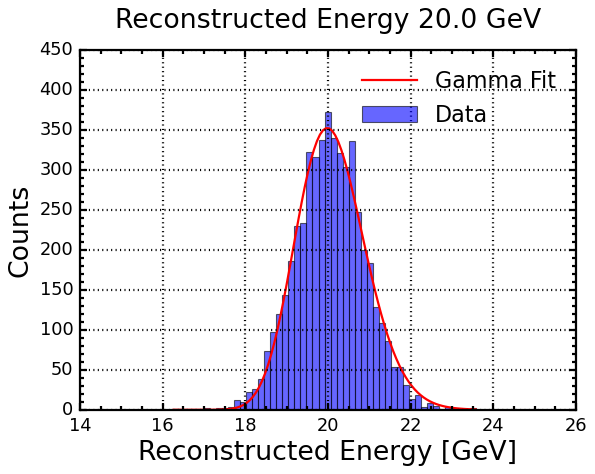

appending results for E = 20.0
Mean_Gamma: 20.108021383821185 Mean_Gamma_Error: 0.02273189607517022
Peak_Gamma: 19.984257454764286 Peak_Gamma_Error: 0.022528327525819094
Mean: 30.071823369011387, Peak: 30.17774179527376, RMS: 1.0285562834176332
Initial Gamma Fit Parameters: [np.float64(791.8542633252024), np.float64(3.669383508591804), np.float64(26.297655904980246), np.float64(1.0285562834176332)]
Gamma Fit Bounds: lower [np.float64(7.918542633252025), np.float64(-0.6330616491408196), np.float64(1.6297655904980246), np.float64(0.10285562834176332)], 
 upper [np.float64(4751.125579951215), np.float64(36.69383508591804), np.float64(49.44648385747037), np.float64(10.285562834176332)]
Gamma Fit Parameters: [7.86534468e+02 3.66938351e+01 2.40068382e+01 1.67213170e-01]
Gamma Fit Peak: 29.975317540187888 ± 0.025050338135258976, Mean: 30.142530710666044 ± 0.02533290602227071, Resolution: 0.0337911709480703 ± 0.000585126762514692


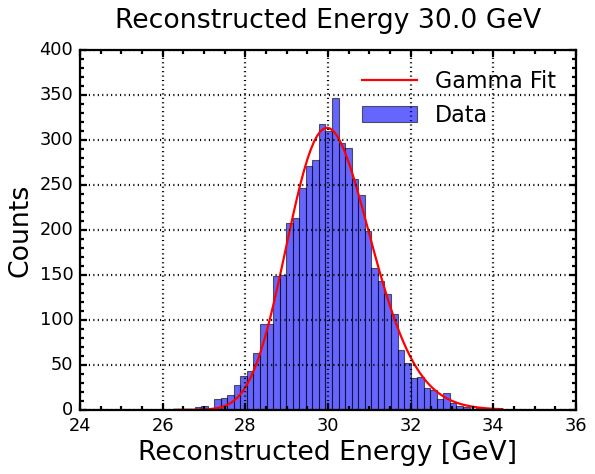

appending results for E = 30.0
Mean_Gamma: 30.142530710666044 Mean_Gamma_Error: 0.02533290602227071
Peak_Gamma: 29.975317540187888 Peak_Gamma_Error: 0.025050338135258976
Mean: 40.10641207797114, Peak: 40.36449158616212, RMS: 1.187465942145841
Initial Gamma Fit Parameters: [np.float64(1008.5077666570687), np.float64(4.624608164062687), np.float64(34.6148473873771), np.float64(1.187465942145841)]
Gamma Fit Bounds: lower [np.float64(10.085077666570687), np.float64(-0.5375391835937313), np.float64(2.4614847387377097), np.float64(0.1187465942145841)], 
 upper [np.float64(6051.046599942412), np.float64(46.24608164062687), np.float64(61.922271081065645), np.float64(11.874659421458409)]
Gamma Fit Parameters: [1.00771203e+03 4.62460816e+01 3.20832953e+01 1.74956037e-01]
Gamma Fit Peak: 39.99937039751094 ± 0.0256312406294549, Mean: 40.174326434089274 ± 0.02586265565248283, Resolution: 0.029744950258668912 ± 0.00043995436321080274


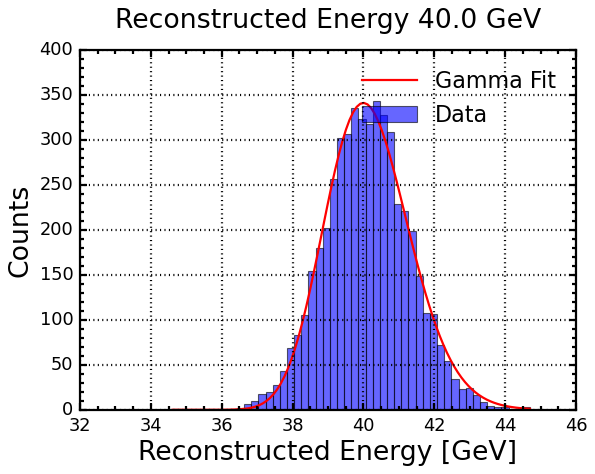

appending results for E = 40.0
Mean_Gamma: 40.174326434089274 Mean_Gamma_Error: 0.02586265565248283
Peak_Gamma: 39.99937039751094 Peak_Gamma_Error: 0.0256312406294549
Mean: 50.04990325241117, Peak: 49.921823456594616, RMS: 1.2979445884878087
Initial Gamma Fit Parameters: [np.float64(1006.7444341776719), np.float64(3.7456699742681208), np.float64(45.18823117904859), np.float64(1.2979445884878087)]
Gamma Fit Bounds: lower [np.float64(10.067444341776719), np.float64(-0.6254330025731879), np.float64(3.5188231179048595), np.float64(0.12979445884878088)], 
 upper [np.float64(6040.466605066032), np.float64(37.45669974268121), np.float64(77.78234676857289), np.float64(12.979445884878087)]
Gamma Fit Parameters: [1.00773110e+03 3.74566997e+01 4.20858176e+01 2.15461277e-01]
Gamma Fit Peak: 49.940824701743004 ± 0.03131244661605243, Mean: 50.15628597911078 ± 0.031661132829937357, Resolution: 0.02640451989368987 ± 0.00043696158044200753


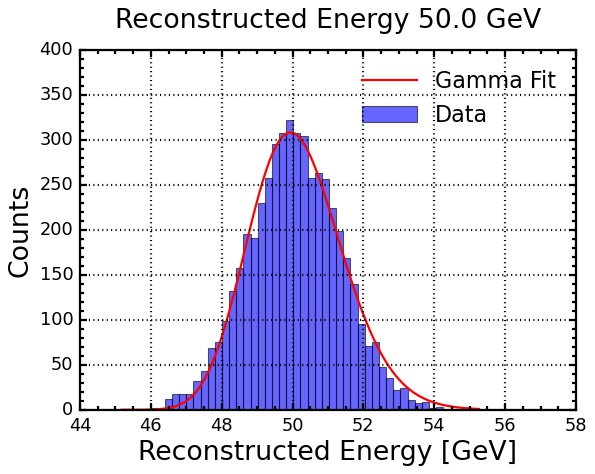

appending results for E = 50.0
Mean_Gamma: 50.15628597911078 Mean_Gamma_Error: 0.031661132829937357
Peak_Gamma: 49.940824701743004 Peak_Gamma_Error: 0.03131244661605243
Mean: 59.75955693890202, Peak: 59.90734744883392, RMS: 1.431645335510695
Initial Gamma Fit Parameters: [np.float64(1283.1468578281574), np.float64(5.1879615949167155), np.float64(52.33223592073088), np.float64(1.431645335510695)]
Gamma Fit Bounds: lower [np.float64(12.831468578281575), np.float64(-0.48120384050832843), np.float64(4.233223592073088), np.float64(0.1431645335510695)], 
 upper [np.float64(7698.881146968944), np.float64(51.87961594916715), np.float64(88.49835388109632), np.float64(14.316453355106951)]
Gamma Fit Parameters: [1.27277457e+03 5.18796159e+01 4.98125439e+01 1.93805549e-01]
Gamma Fit Peak: 59.673295756225684 ± 0.031111755086834367, Mean: 59.867101304953756 ± 0.031361872732046096, Resolution: 0.023392926622189836 ± 0.00035439347071763446


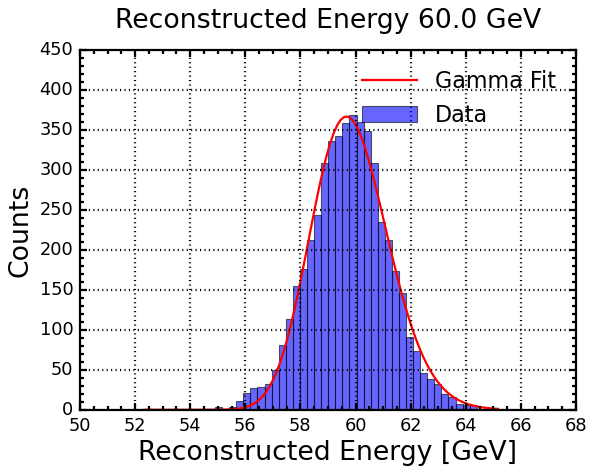

appending results for E = 60.0
Mean_Gamma: 59.867101304953756 Mean_Gamma_Error: 0.031361872732046096
Peak_Gamma: 59.673295756225684 Peak_Gamma_Error: 0.031111755086834367
Results saved to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X10.0mm_Y10.0mm_Si0.75mm_layer30_in120/Reco_Results/RecoE_MLP_Threshold0.1_WD1e-8_Fit.csv


In [36]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
def OutputCSV(Reco_hist, Energy_test, best_val_loss, CSV_name):
    results = []
    for i_E in range(len(Energy_test)):
        mean_gauss,mean_gauss_error,peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0, 0, 0
        mean_log_normal,mean_log_normal_error,peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0, 0, 0
        mean_gamma,mean_gamma_error,peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Reco_hist[i_E]["E_truth"],Reco_hist[i_E]["counts"],Reco_hist[i_E]["bin_edges"])
        print("appending results for E =", Energy_test[i_E])
        print("Mean_Gamma:", mean_gamma, "Mean_Gamma_Error:", mean_gamma_error)
        print("Peak_Gamma:", peak_gamma, "Peak_Gamma_Error:", peak_gamma_error)
        results.append({
            "ParticleEnergy": Energy_test[i_E],
            "Mean_Gauss": mean_gauss,
            "Mean_Gauss_Error": mean_gauss_error,
            "Peak_Gauss": peak_gauss,
            "Peak_Gauss_Error": peak_gauss_error,
            "Res_Gauss": res_gauss,
            "Res_Gauss_Error": res_gauss_error,
            "Mean_Gamma": mean_gamma,
            "Mean_Gamma_Error": mean_gamma_error,
            "Peak_Gamma": peak_gamma,
            "Peak_Gamma_Error": peak_gamma_error,
            "Res_Gamma": res_gamma,
            "Res_Gamma_Error": res_gamma_error,
            "Mean_LogNormal": mean_log_normal,
            "Mean_LogNormal_Error": mean_log_normal_error,
            "Peak_LogNormal": peak_log_normal,
            "Peak_LogNormal_Error": peak_log_normal_error,
            "Res_LogNormal": res_log_normal,
            "Res_LogNormal_Error": res_log_normal_error,
            "Best_Val_Loss": best_val_loss
        })
    df = pd.DataFrame(results)
    df.to_csv(CSV_name, index=False)
    print(f"Results saved to {CSV_name}")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_{MLP_Config}_Fit.csv")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit_Threshold{Threshold_i}.csv")
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Threshold{Threshold_i}_{MLP_Config}_Fit.csv")
OutputCSV(Reco_hist_mlp_all[0], Energy_test, best_val_loss, outputfile_name)
# for i_para, para in enumerate(ParameterScan):
#     if i_para != 0:
#         continue  # 
#     #outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_LR{para:.0e}_Fit.csv")
#     outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/RecoE_MLP_Fit.csv")
#     OutputCSV(Reco_hist_mlp_all[i_para], Energy_test, outputfile_name)
#     print(f"Saved fit results to {outputfile_name}")